In [1]:
# Improve by ChatGPT & GitHub Copilot

# Running the requierements.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/OSSE_generator/requierements.ipynb

#%matplotlib widget

# Loading the data
SSH + mask

In [2]:
SSH = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60/*_SSH.nc", combine="nested", concat_dim="time_counter", parallel=True)
mask = xr.open_dataset('/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60/1_mesh_mask_TROPICO12_L125_tr21.nc',drop_variables={"x","y"}) 
masked_SSH = SSH['zos'].where(mask.tmaskutil[0,:,:] == 1)#.load()

In [2]:
masked_SSH


<xarray.DataArray 'zos' (time_counter: 8760, y: 853, x: 788)>
dask.array<where, shape=(8760, 853, 788), dtype=float32, chunksize=(744, 853, 788), chunktype=numpy.ndarray>
Coordinates:
    nav_lat       (y, x) float32 dask.array<chunksize=(853, 788), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(853, 788), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2014-01-01T00:30:00 ... 2014-...
    time_instant  (time_counter) datetime64[ns] dask.array<chunksize=(744,), meta=np.ndarray>
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_surface_height_above_geoid
    long_name:           sea surface height
    units:               m
    online_operation:    instant
    interval_operation:  1 h
    interval_write:      1 h
    cell_methods:        time: point

# Is the mask working?

In [3]:
# Assuming your DataArray is named `data_array`
SSH_mask_1h = masked_SSH.sel(time_counter='2014-01-01 00:30')

In [4]:
SSH_mask_1h

<xarray.DataArray 'zos' (y: 853, x: 788)>
dask.array<getitem, shape=(853, 788), dtype=float32, chunksize=(853, 788), chunktype=numpy.ndarray>
Coordinates:
    nav_lat       (y, x) float32 dask.array<chunksize=(853, 788), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(853, 788), meta=np.ndarray>
    time_counter  datetime64[ns] 2014-01-01T00:30:00
    time_instant  datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_surface_height_above_geoid
    long_name:           sea surface height
    units:               m
    online_operation:    instant
    interval_operation:  1 h
    interval_write:      1 h
    cell_methods:        time: point

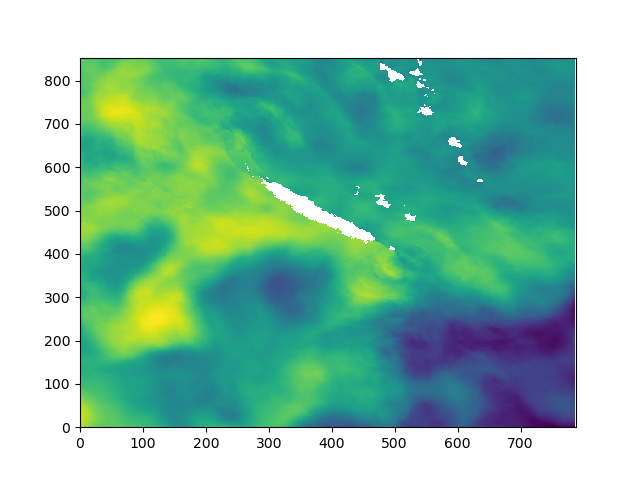

In [5]:
plt.pcolormesh(SSH_mask_1h)
#plt.show()

# Making the time Series

In [2]:
masked_SSH = masked_SSH.compute() # to ensure it's loaded

## Selecting the region and computing the mean

In [3]:
####################
### For region A ###
####################

mask_nc_a = (masked_SSH.nav_lat >= -27) & (masked_SSH.nav_lat <= -23) & (masked_SSH.nav_lon >= 161) & (masked_SSH.nav_lon <= 165) # to select the region

subset_SSH_a = masked_SSH.where(mask_nc_a) # to ensure that the dimensions are preserved even if some elements are masked out.

# Now computing the mean 'zos' value for each time step, ignoring missing values
MSS_TS_a = subset_SSH_a.mean(dim=['x', 'y'], skipna=True).compute() #Since 'MSS_TS_a' is a Dask array, it needs to be compute it before plotting

In [4]:
# Export to NetCDF, in case the kernel crush
MSS_TS_a.to_netcdf('/home/riverama/Documents/Analisis/MSS_TS_a.nc')

In [3]:
####################
### For region B ###
####################

mask_nc_b = (masked_SSH.nav_lat >= -21) & (masked_SSH.nav_lat <= -17) & (masked_SSH.nav_lon >= 167) & (masked_SSH.nav_lon <= 171) # to select the region

subset_SSH_b = masked_SSH.where(mask_nc_b) # to ensure that the dimensions are preserved even if some elements are masked out.

# Now computing the mean 'zos' value for each time step, ignoring missing values
MSS_TS_b = subset_SSH_b.mean(dim=['x', 'y'], skipna=True).compute() #Since 'MSS_TS_a' is a Dask array, it needs to be compute it before plotting

In [4]:
# Export to NetCDF, in case the kernel crush
MSS_TS_b.to_netcdf('/home/riverama/Documents/Analisis/MSS_TS_b.nc')

## Loading the results in case the kernel crushed

In [6]:
MSS_TS_a = xr.open_mfdataset("/home/riverama/Documents/Analisis/MSS_TS_a.nc")
MSS_TS_b = xr.open_mfdataset("/home/riverama/Documents/Analisis/MSS_TS_b.nc")

## Plots

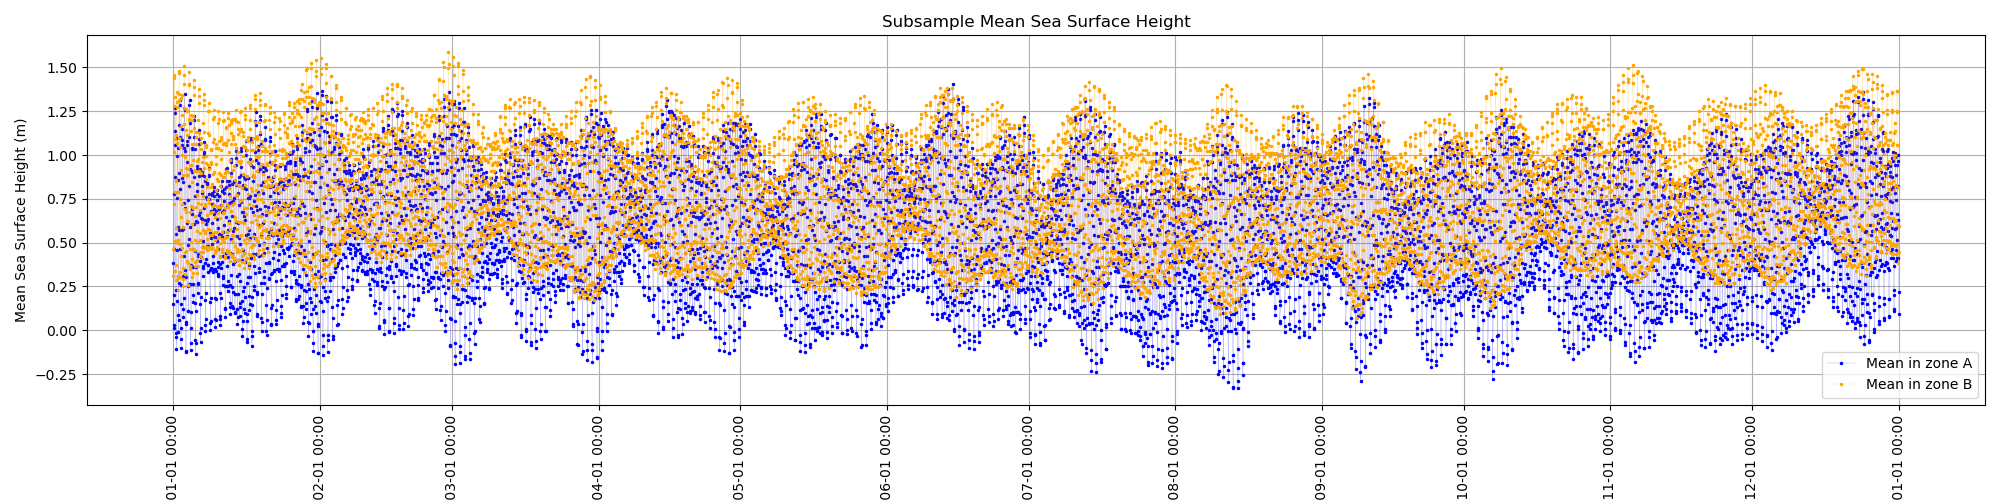

In [9]:
# Plotting
plt.figure(figsize=(20, 5))

# Select the time range
plt.plot(MSS_TS_a['time_counter'], MSS_TS_a['zos'],label='Mean in zone A', marker='.', markersize=3, linestyle='-', linewidth=0.1, color='blue')
plt.plot(MSS_TS_b['time_counter'], MSS_TS_b['zos'],label='Mean in zone B', marker='.', markersize=3, linestyle='-', linewidth=0.1, color='orange')

plt.title('Subsample Mean Sea Surface Height')
plt.xlabel('Time')
plt.ylabel('Mean Sea Surface Height (m)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()

# Set daily x-axis markers and format the date
#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1)) # for daily markers
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) # for monthly markers
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M')) # to format the date

plt.xticks(rotation=90) # to rotate the x-axis labels
plt.show()